In [4]:
import pandas as pd
import numpy as np
from statsmodels.tools import add_constant
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from tqdm import tqdm

100%|████████████████████████████████████████████████████████████████████████████████| 257/257 [00:03<00:00, 67.92it/s]


        date  best_lag          beta      pval        r2  risk_score
0 2002-09-01        12 -52596.737039  0.036316  0.160364         0.0
1 2002-10-01        12 -47446.410929  0.035186  0.142765         0.0
2 2002-11-01        12 -48072.552521  0.031335  0.146763         0.0
3 2002-12-01        12 -47928.746355  0.030994  0.145784         0.0
4 2003-01-01        12 -53605.334924  0.011694  0.163121         0.0


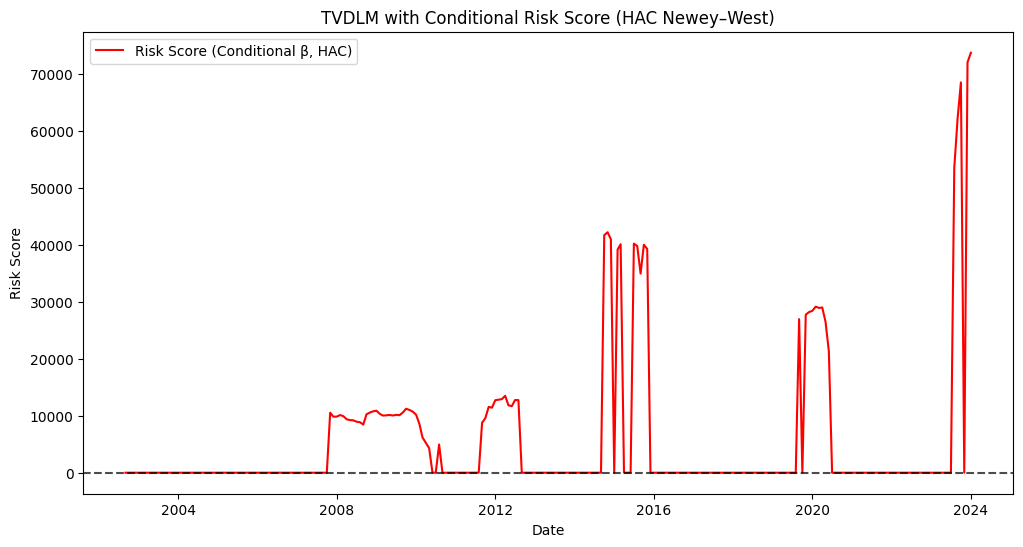

In [5]:
# 1. 데이터 불러오기
df = pd.read_csv('regression.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df.drop(0, axis=0, inplace=True)

# 2. 파라미터 설정
window_size = 36  # 3년 단위 윈도우
max_lag = 12      # 최대 1년 시차

# 결과 저장용 리스트
results = []

# 3. 슬라이딩 윈도우
for start in tqdm(range(len(df) - window_size + 1)):
    end = start + window_size
    window_df = df.iloc[start:end].copy()

    best_r2 = -np.inf
    best_lag = None
    best_beta = None
    best_pval = None

    # lag별 회귀 성능 비교
    for lag in range(0, max_lag + 1):
        X = window_df['HK_exports_to_Korea_logdiff'].shift(lag)
        y = window_df['seizure_diff']

        valid_idx = X.notna() & y.notna()
        X_valid = X[valid_idx]
        y_valid = y[valid_idx]

        if len(X_valid) < 10:
            continue

        X_valid = sm.add_constant(X_valid)
        # OLS + HAC(Newey–West) 표준오차 보정
        model = sm.OLS(y_valid, X_valid).fit(
            cov_type='HAC', 
            cov_kwds={'maxlags': lag if lag > 0 else 1}  # 최소 1
        )

        if model.rsquared > best_r2:
            best_r2 = model.rsquared
            best_lag = lag
            best_beta = model.params.iloc[1]
            best_pval = model.pvalues.iloc[1]

    # 조건부 위험도 계산
    if (best_beta is not None) and (best_beta > 0) and (best_pval < 0.05):
        risk_score = best_beta
    else:
        risk_score = 0

    # 윈도우 중앙 시점 기준 기록
    mid_date = window_df['date'].iloc[window_size // 2]
    results.append({
        'date': mid_date,
        'best_lag': best_lag,
        'beta': best_beta,
        'pval': best_pval,
        'r2': best_r2,
        'risk_score': risk_score
    })

# 4. 결과 저장
result_df = pd.DataFrame(results)
result_df.to_csv('tvdml_results_with_risk_hac.csv', index=False)

print(result_df.head())

# 5. 위험도 시계열 시각화
plt.figure(figsize=(12,6))
plt.plot(result_df['date'], result_df['risk_score'], label='Risk Score (Conditional β, HAC)', color='red')
plt.axhline(0, color='black', linestyle='--', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Risk Score')
plt.title('TVDLM with Conditional Risk Score (HAC Newey–West)')
plt.legend()
plt.show()

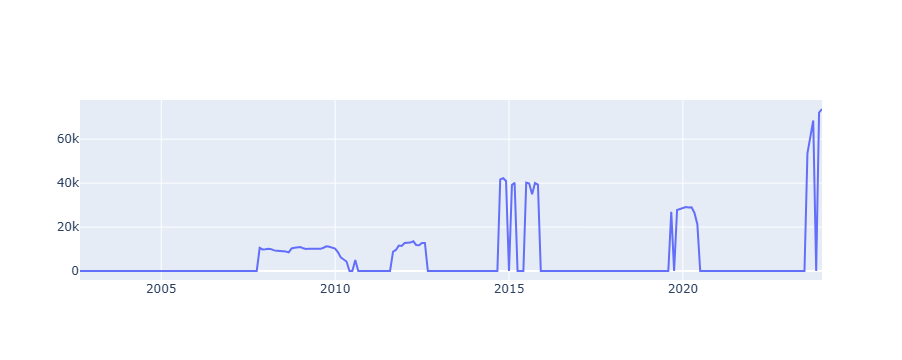

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result_df['date'], y=result_df['risk_score'], mode='lines'))
fig.show()

In [10]:
# 1. 데이터 불러오기
df = pd.read_csv('regression.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)
df.drop(0, axis=0, inplace=True)


def ols(window_size=36, max_lag=12) : # 3년 단위 윈도우, 최대 1년 시차
    
    # 결과 저장용 리스트
    results = []
    
    # 3. 슬라이딩 윈도우
    for start in tqdm(range(len(df) - window_size + 1)):
        end = start + window_size
        window_df = df.iloc[start:end].copy()
    
        best_r2 = -np.inf
        best_lag = None
        best_beta = None
        best_pval = None
    
        # lag별 회귀 성능 비교
        for lag in range(0, max_lag + 1):
            X = window_df['HK_exports_to_Korea_logdiff'].shift(lag)
            y = window_df['seizure_diff']
    
            valid_idx = X.notna() & y.notna()
            X_valid = X[valid_idx]
            y_valid = y[valid_idx]
    
            if len(X_valid) < 10:
                continue
    
            X_valid = sm.add_constant(X_valid)
            # OLS + HAC(Newey–West) 표준오차 보정
            model = sm.OLS(y_valid, X_valid).fit(
                cov_type='HAC', 
                cov_kwds={'maxlags': lag if lag > 0 else 1}  # 최소 1
            )
    
            if model.rsquared > best_r2:
                best_r2 = model.rsquared
                best_lag = lag
                best_beta = model.params.iloc[1]
                best_pval = model.pvalues.iloc[1]
    
        # 조건부 위험도 계산
        if (best_beta is not None) and (best_beta > 0) and (best_pval < 0.05):
            risk_score = best_beta
        else:
            risk_score = 0
    
        # 윈도우 중앙 시점 기준 기록
        mid_date = window_df['date'].iloc[window_size // 2]
        results.append({
            'date': mid_date,
            'best_lag': best_lag,
            'beta': best_beta,
            'pval': best_pval,
            'r2': best_r2,
            'risk_score': risk_score
        })
    
    # 4. 결과 저장
    result_df = pd.DataFrame(results)
    result_df.to_csv('tvdml_results_with_risk_hac.csv', index=False)
    
    print(result_df.head())
    '''
    # 5. 위험도 시계열 시각화
    plt.figure(figsize=(12,6))
    plt.plot(result_df['date'], result_df['risk_score'], label='Risk Score (Conditional β, HAC)', color='red')
    plt.axhline(0, color='black', linestyle='--', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('Risk Score')
    plt.title('TVDLM with Conditional Risk Score (HAC Newey–West)')
    plt.legend()
    plt.show()
    '''
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=result_df['date'], y=result_df['risk_score'], mode='lines'))
    fig.show()
    
    return result_df

100%|███████████████████████████████████████████████████████████████████████████████| 281/281 [00:01<00:00, 165.45it/s]

        date  best_lag           beta      pval        r2     risk_score
0 2001-09-01         0  282067.920386  0.035262  0.225754  282067.920386
1 2001-10-01         0  119746.769619  0.206967  0.094041       0.000000
2 2001-11-01         0   89261.086663  0.215714  0.073658       0.000000
3 2001-12-01         0   95427.353155  0.189550  0.091854       0.000000
4 2002-01-01         0   64299.150108  0.330067  0.041897       0.000000


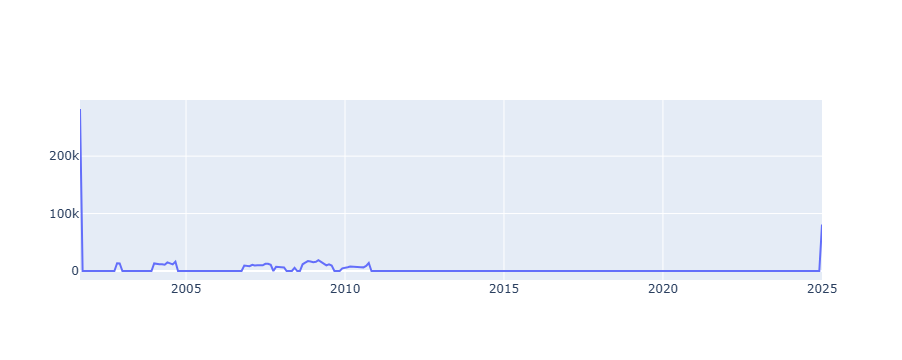

,date,best_lag,beta,pval,r2,risk_score
0,2001-09-01,0,282067.920386,0.035262,0.225754,282067.920386
1,2001-10-01,0,119746.769619,0.206967,0.094041,0.000000
2,2001-11-01,0,89261.086663,0.215714,0.073658,0.000000
3,2001-12-01,0,95427.353155,0.189550,0.091854,0.000000
4,2002-01-01,0,64299.150108,0.330067,0.041897,0.000000
...,...,...,...,...,...,...
276,2024-09-01,2,-28430.912879,0.126712,0.053937,0.000000
277,2024-10-01,1,36622.456313,0.459538,0.089349,0.000000
278,2024-11-01,2,-49164.924508,0.010573,0.156335,0.000000
279,2024-12-01,2,-56669.666840,0.025091,0.215199,0.000000


In [11]:
ols(window_size=12, max_lag=12)

100%|████████████████████████████████████████████████████████████████████████████████| 269/269 [00:04<00:00, 66.93it/s]

        date  best_lag          beta      pval        r2    risk_score
0 2002-03-01        12 -17727.024855  0.022027  0.212285      0.000000
1 2002-04-01         9  10327.557484  0.012395  0.175434  10327.557484
2 2002-05-01         8 -11908.812365  0.001952  0.260809      0.000000
3 2002-06-01         9  10474.425487  0.001325  0.276054  10474.425487
4 2002-07-01        12 -38955.512683  0.009435  0.135691      0.000000


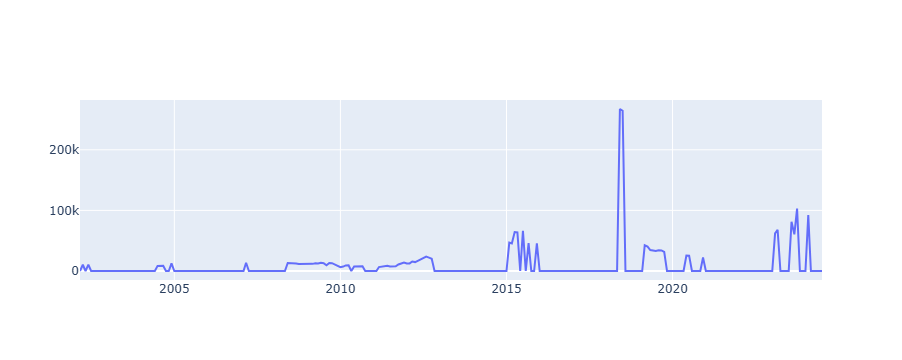

,date,best_lag,beta,pval,r2,risk_score
0,2002-03-01,12,-17727.024855,2.202713e-02,0.212285,0.000000
1,2002-04-01,9,10327.557484,1.239493e-02,0.175434,10327.557484
2,2002-05-01,8,-11908.812365,1.951551e-03,0.260809,0.000000
3,2002-06-01,9,10474.425487,1.325388e-03,0.276054,10474.425487
4,2002-07-01,12,-38955.512683,9.435212e-03,0.135691,0.000000
...,...,...,...,...,...,...
264,2024-03-01,7,-76221.021568,9.586288e-02,0.181063,0.000000
265,2024-04-01,7,-78383.597728,5.183315e-02,0.207668,0.000000
266,2024-05-01,7,-87796.882933,5.326124e-05,0.417835,0.000000
267,2024-06-01,7,-98826.457359,1.317927e-08,0.429806,0.000000


In [12]:
#최적인 듯
ols(window_size=24, max_lag=12)

100%|████████████████████████████████████████████████████████████████████████████████| 257/257 [00:03<00:00, 66.00it/s]

        date  best_lag          beta      pval        r2  risk_score
0 2002-09-01        12 -52596.737039  0.036316  0.160364         0.0
1 2002-10-01        12 -47446.410929  0.035186  0.142765         0.0
2 2002-11-01        12 -48072.552521  0.031335  0.146763         0.0
3 2002-12-01        12 -47928.746355  0.030994  0.145784         0.0
4 2003-01-01        12 -53605.334924  0.011694  0.163121         0.0


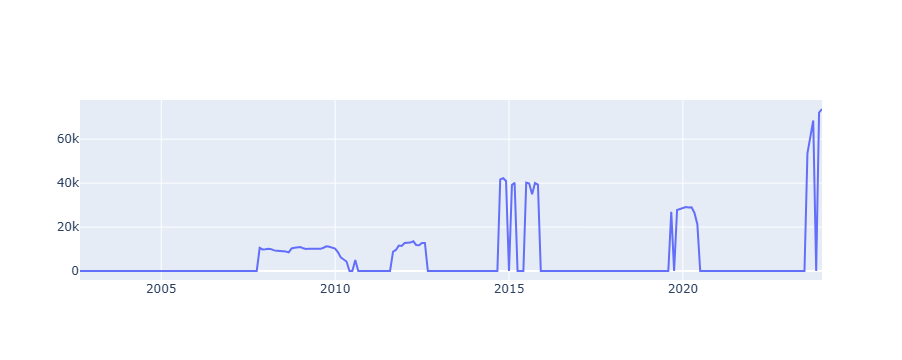

,date,best_lag,beta,pval,r2,risk_score
0,2002-09-01,12,-52596.737039,3.631645e-02,0.160364,0.000000
1,2002-10-01,12,-47446.410929,3.518649e-02,0.142765,0.000000
2,2002-11-01,12,-48072.552521,3.133539e-02,0.146763,0.000000
3,2002-12-01,12,-47928.746355,3.099413e-02,0.145784,0.000000
4,2003-01-01,12,-53605.334924,1.169420e-02,0.163121,0.000000
...,...,...,...,...,...,...
252,2023-09-01,11,62276.160192,3.872207e-06,0.259877,62276.160192
253,2023-10-01,11,68517.668859,6.815924e-08,0.325973,68517.668859
254,2023-11-01,10,-69157.155473,4.143806e-04,0.331756,0.000000
255,2023-12-01,11,72042.205860,1.412536e-10,0.339975,72042.205860


In [13]:
ols(window_size=36, max_lag=12)

100%|████████████████████████████████████████████████████████████████████████████████| 245/245 [00:03<00:00, 65.27it/s]

        date  best_lag          beta      pval        r2  risk_score
0 2003-03-01        12 -39220.153541  0.074817  0.114361         0.0
1 2003-04-01        12 -38681.621249  0.072028  0.114975         0.0
2 2003-05-01        12 -38479.442474  0.071017  0.115637         0.0
3 2003-06-01        12 -38357.013868  0.070785  0.115658         0.0
4 2003-07-01        12 -41988.421247  0.049431  0.127681         0.0


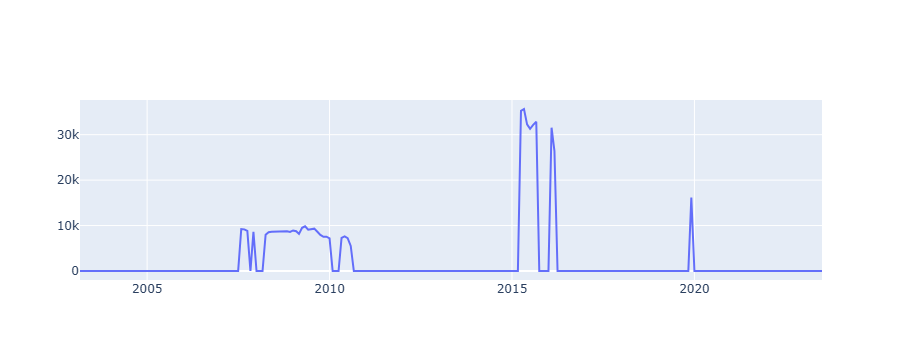

,date,best_lag,beta,pval,r2,risk_score
0,2003-03-01,12,-39220.153541,0.074817,0.114361,0.0
1,2003-04-01,12,-38681.621249,0.072028,0.114975,0.0
2,2003-05-01,12,-38479.442474,0.071017,0.115637,0.0
3,2003-06-01,12,-38357.013868,0.070785,0.115658,0.0
4,2003-07-01,12,-41988.421247,0.049431,0.127681,0.0
...,...,...,...,...,...,...
240,2023-03-01,5,116951.505557,0.100494,0.055090,0.0
241,2023-04-01,10,-51225.694066,0.015356,0.163021,0.0
242,2023-05-01,10,-52322.145308,0.009308,0.170435,0.0
243,2023-06-01,10,-54245.835447,0.004538,0.179548,0.0


In [14]:
ols(window_size=48, max_lag=12)